<a href="https://colab.research.google.com/github/akankhyapanda/CRM/blob/main/CRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install xlrd
!pip install openpyxl
!pip install lifetimes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
import warnings
warnings.filterwarnings("ignore")


In [32]:
! unzip online_retail_II.zip

Archive:  online_retail_II.zip
replace online_retail_II.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [33]:
import pandas as pd

# Replace 'online_retail_II.xlsx' with the name of your uploaded file
file_path = "/content/online_retail_II.xlsx"

# Read the specific sheet
df1 = pd.read_excel(file_path, sheet_name="Year 2009-2010")

# Preview the data
print(df1.head())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [34]:
df=df1.copy()

In [35]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(df)

##################### Shape #####################
(525461, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
##################### Tail #####################
       Invoice 

In [36]:
df.describe([0.01,0.50,0.99]).T

,count,mean,min,1%,50%,99%,max,std
Quantity,525461.0,10.337667,-9600.0,-3.0,3.0,120.0,19152.0,107.42411
InvoiceDate,525461,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2009-12-02 14:36:00,2010-07-06 09:51:00,2010-12-08 10:40:00,2010-12-09 20:01:00,NaN
Price,525461.0,4.688834,-53594.36,0.21,2.1,19.95,25111.09,146.126914
Customer ID,417534.0,15360.645478,12346.0,12435.0,15311.0,18196.0,18287.0,1680.811316


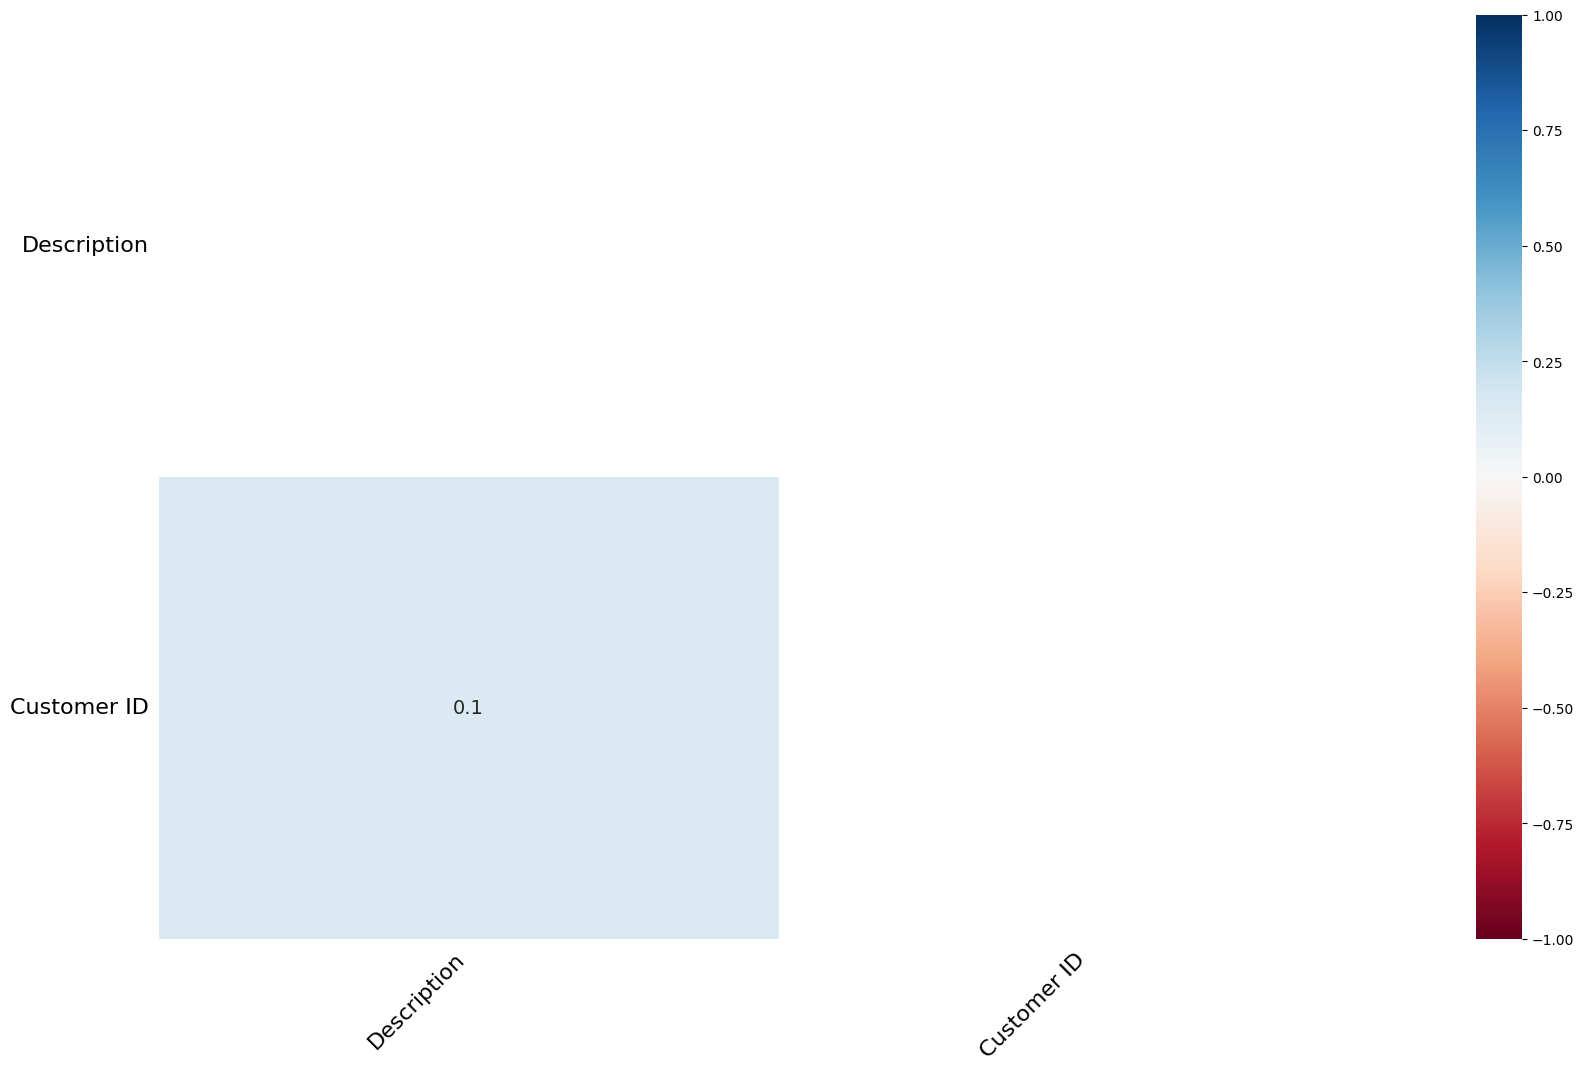

In [37]:
msno.heatmap(df);

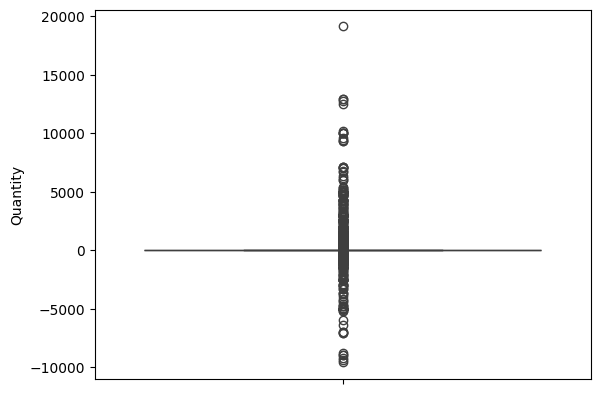

In [38]:
sns.boxplot(df["Quantity"]);

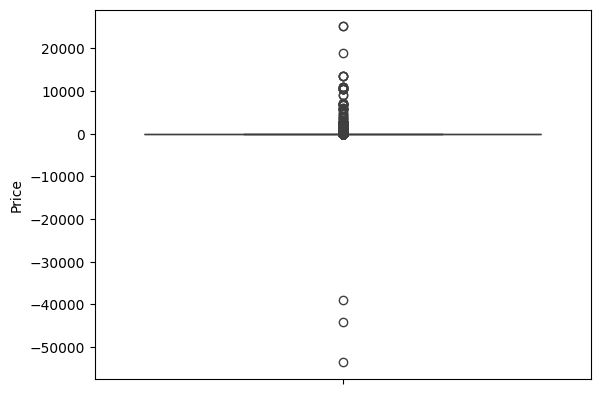

In [39]:
sns.boxplot(df["Price"]);

Data Preprocessing

In [40]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [41]:
replace_with_thresholds(df,"Quantity")
replace_with_thresholds(df,"Price")

In [42]:
def crm_data_prep(dataframe):
    dataframe.dropna(axis=0, inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    return dataframe

In [43]:
df=crm_data_prep(df)
check_df(df)

##################### Shape #####################
(407695, 9)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
TotalPrice            float64
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom 

<Axes: ylabel='Quantity'>

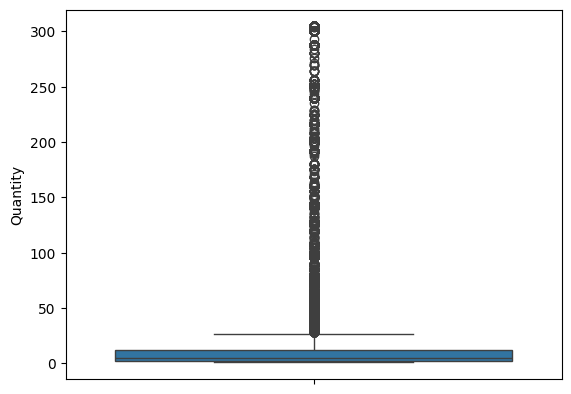

In [44]:
sns.boxplot(df["Quantity"])

RFM

In [45]:
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

In [46]:
def create_rfm(dataframe):
    # RFM Metrics


    today_date = dt.datetime(2010, 12, 11)

    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})

    rfm.columns = ['recency', 'frequency', "monetary"]

    rfm = rfm[(rfm['monetary'] > 0)]


    # RFM score
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])


    # segment naming
    rfm['rfm_segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)

    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    rfm['rfm_segment'] = rfm['rfm_segment'].replace(seg_map, regex=True)
    rfm = rfm[["recency", "frequency", "monetary", "rfm_segment"]]
    return rfm


In [47]:
rfm = create_rfm(df)
rfm.head()

,recency,frequency,monetary,rfm_segment
Customer ID,,,,
12346.0,165,11,372.86,cant_loose
12347.0,3,2,1323.32,potential_loyalists
12348.0,74,1,222.16,hibernating
12349.0,43,3,2320.26,need_attention
12351.0,11,1,300.93,new_customers


<Axes: xlabel='rfm_segment', ylabel='frequency'>

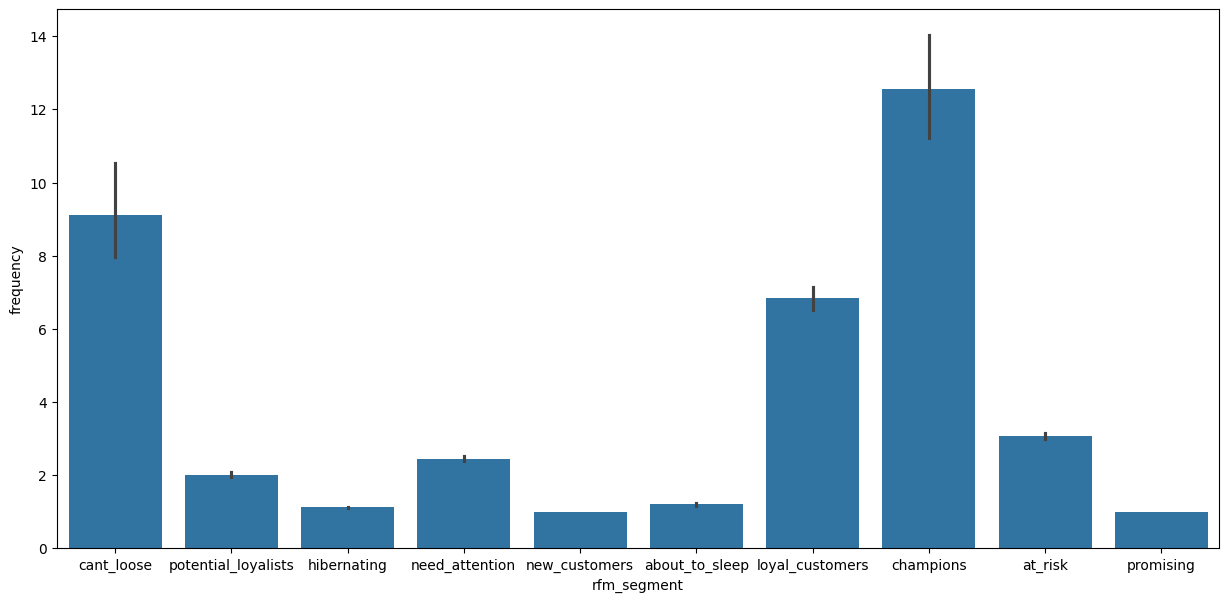

In [48]:
plt.figure(figsize=(15,7))
sns.barplot(x="rfm_segment", y="frequency", data=rfm)

In [49]:
check_df(rfm)

##################### Shape #####################
(4312, 4)
##################### Types #####################
recency          int64
frequency        int64
monetary       float64
rfm_segment     object
dtype: object
##################### Head #####################
             recency  frequency  monetary          rfm_segment
Customer ID                                                   
12346.0          165         11    372.86           cant_loose
12347.0            3          2   1323.32  potential_loyalists
12348.0           74          1    222.16          hibernating
##################### Tail #####################
             recency  frequency  monetary      rfm_segment
Customer ID                                               
18285.0          296          1    426.56      hibernating
18286.0          112          2   1295.99          at_risk
18287.0           18          4   2345.27  loyal_customers
##################### NA #####################
recency        0
frequency   

CLTV Calculated

In [50]:
def create_cltv_calculated(dataframe):
    # avg_order_value
    dataframe['avg_order_value'] = dataframe['monetary'] / dataframe['frequency']

    # purchase_frequency
    dataframe["purchase_frequency"] = dataframe['frequency'] / dataframe.shape[0]

    # repeat rate & churn rate
    repeat_rate = dataframe[dataframe.frequency > 1].shape[0] / dataframe.shape[0]
    churn_rate = 1 - repeat_rate

    # profit_margin
    dataframe['profit_margin'] = dataframe['monetary'] * 0.05

    # Customer Value
    dataframe['cv'] = (dataframe['avg_order_value'] * dataframe["purchase_frequency"])

    # Customer Lifetime Value
    dataframe['cltv'] = (dataframe['cv'] / churn_rate) * dataframe['profit_margin']

    # minmaxscaler
    scaler = MinMaxScaler(feature_range=(1, 100))
    scaler.fit(dataframe[["cltv"]])
    dataframe["cltv_calculated"] = scaler.transform(dataframe[["cltv"]])

    dataframe["cltv_calculated_segment"] = pd.qcut(dataframe["cltv_calculated"], 3, labels=["C", "B", "A"])

    dataframe = dataframe[["recency", "frequency", "monetary", "rfm_segment",
                           "cltv_calculated", "cltv_calculated_segment"]]

    return dataframe


In [51]:
rfm_cltv = create_cltv_calculated(rfm)
check_df(rfm_cltv)


##################### Shape #####################
(4312, 6)
##################### Types #####################
recency                       int64
frequency                     int64
monetary                    float64
rfm_segment                  object
cltv_calculated             float64
cltv_calculated_segment    category
dtype: object
##################### Head #####################
             recency  frequency  monetary          rfm_segment  \
Customer ID                                                      
12346.0          165         11    372.86           cant_loose   
12347.0            3          2   1323.32  potential_loyalists   
12348.0           74          1    222.16          hibernating   

             cltv_calculated cltv_calculated_segment  
Customer ID                                           
12346.0             1.000150                       C  
12347.0             1.001888                       A  
12348.0             1.000053                       C  
#####

<Axes: xlabel='rfm_segment', ylabel='cltv_calculated'>

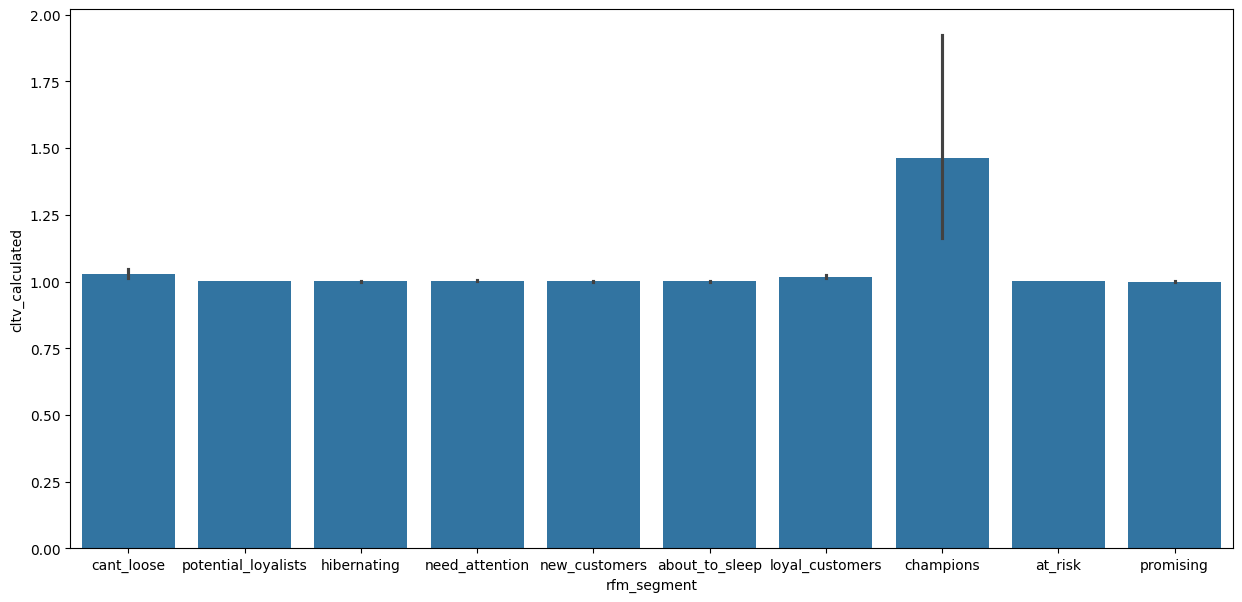

In [52]:
plt.figure(figsize=(15,7))
sns.barplot(x="rfm_segment", y="cltv_calculated", data=rfm_cltv)

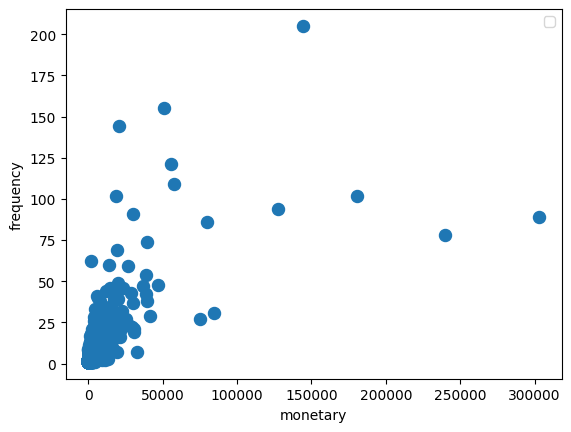

In [53]:
# The correlation seems very weak.

plt.scatter(rfm_cltv.monetary,rfm_cltv.frequency,s=75)


plt.xlabel("monetary")
plt.ylabel("frequency")
plt.legend()
plt.show()


In [54]:
def create_cltv_predicted(dataframe):
    today_date = dt.datetime(2010, 12, 11)

    ## recency value customized
    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                                                lambda date: (today_date - date.min()).days],
                                                'Invoice': lambda num: num.nunique(),
                                                'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    rfm.columns = rfm.columns.droplevel(0)

    ## recency_cltv_predicted
    rfm.columns = ['recency_cltv_predicted', 'T', 'frequency', 'monetary']

    ## basic monetary_avg
    rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

    rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)



    ## recency_weekly_cltv_predicted
    rfm["recency_weekly_cltv_predicted"] = rfm["recency_cltv_predicted"] / 7
    rfm["T_weekly"] = rfm["T"] / 7

    # CONTROL
    rfm = rfm[rfm["monetary_avg"] > 0]

    ## recency filter
    rfm = rfm[(rfm['frequency'] > 1)]

    rfm["frequency"] = rfm["frequency"].astype(int)

    # BGNBD
    bgf = BetaGeoFitter(penalizer_coef=0.01)
    bgf.fit(rfm['frequency'],
            rfm['recency_weekly_cltv_predicted'],
            rfm['T_weekly'])


    # Gamma Gamma
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(rfm['frequency'], rfm['monetary_avg'])
    rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                             rfm['monetary_avg'])
    # 6 months cltv_p
    cltv = ggf.customer_lifetime_value(bgf,
                                       rfm['frequency'],
                                       rfm['recency_weekly_cltv_predicted'],
                                       rfm['T_weekly'],
                                       rfm['monetary_avg'],
                                       time=6,
                                       freq="W",
                                       discount_rate=0.01)

    rfm["cltv_predicted"] = cltv

    # minmaxscaler
    scaler = MinMaxScaler(feature_range=(1, 100))
    scaler.fit(rfm[["cltv_predicted"]])
    rfm["cltv_predicted"] = scaler.transform(rfm[["cltv_predicted"]])

    # rfm.fillna(0, inplace=True)

    # cltv_predicted_segment
    rfm["cltv_predicted_segment"] = pd.qcut(rfm["cltv_predicted"], 3, labels=["C", "B", "A"])

    ## recency_cltv_predicted, recency_weekly_cltv_predicted
    rfm = rfm[["recency_cltv_predicted", "T", "monetary_avg", "recency_weekly_cltv_predicted", "T_weekly",
               "expected_average_profit","cltv_predicted", "cltv_predicted_segment"]]


    return rfm

In [55]:
rfm_cltv_predicted = create_cltv_predicted(df)
check_df(rfm_cltv_predicted)

##################### Shape #####################
(2893, 8)
##################### Types #####################
recency_cltv_predicted              int64
T                                   int64
monetary_avg                      float64
recency_weekly_cltv_predicted     float64
T_weekly                          float64
expected_average_profit           float64
cltv_predicted                    float64
cltv_predicted_segment           category
dtype: object
##################### Head #####################
             recency_cltv_predicted    T  monetary_avg  \
Customer ID                                              
12346.0                         196  361     33.896364   
12347.0                          37   40    661.660000   
12349.0                         181  225    773.420000   

             recency_weekly_cltv_predicted   T_weekly  \
Customer ID                                             
12346.0                          28.000000  51.571429   
12347.0                      

CRM

In [56]:
crm_final = rfm_cltv.merge(rfm_cltv_predicted, on="Customer ID", how="left")
check_df(crm_final)

##################### Shape #####################
(4312, 14)
##################### Types #####################
recency                             int64
frequency                           int64
monetary                          float64
rfm_segment                        object
cltv_calculated                   float64
cltv_calculated_segment          category
recency_cltv_predicted            float64
T                                 float64
monetary_avg                      float64
recency_weekly_cltv_predicted     float64
T_weekly                          float64
expected_average_profit           float64
cltv_predicted                    float64
cltv_predicted_segment           category
dtype: object
##################### Head #####################
             recency  frequency  monetary          rfm_segment  \
Customer ID                                                      
12346.0          165         11    372.86           cant_loose   
12347.0            3          2   1323.3

In [57]:
crm_final.sort_values(by="monetary_avg", ascending=False).head()

,recency,frequency,monetary,rfm_segment,cltv_calculated,cltv_calculated_segment,recency_cltv_predicted,T,monetary_avg,recency_weekly_cltv_predicted,T_weekly,expected_average_profit,cltv_predicted,cltv_predicted_segment
Customer ID,,,,,,,,,,,,,,
12357.0,24,2,11279.55,potential_loyalists,1.137135,A,0.0,24.0,5639.775000,0.000000,3.428571,6178.891147,33.204317,A
17450.0,3,7,33132.20,champions,2.183222,A,70.0,74.0,4733.171429,10.000000,10.571429,4854.298121,42.870766,A
14091.0,290,2,9110.85,hibernating,1.089471,A,44.0,334.0,4555.425000,6.285714,47.714286,4991.278829,2.187712,A
14088.0,42,3,13544.99,need_attention,1.197753,A,14.0,57.0,4514.996667,2.000000,8.142857,4794.138374,22.742626,A
18102.0,1,89,303064.29,champions,100.000000,A,373.0,374.0,3405.216742,53.285714,53.428571,3411.925276,100.000000,A
